In [1]:
import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Functions import *
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from tabulate import tabulate
from Convolution import createWaves

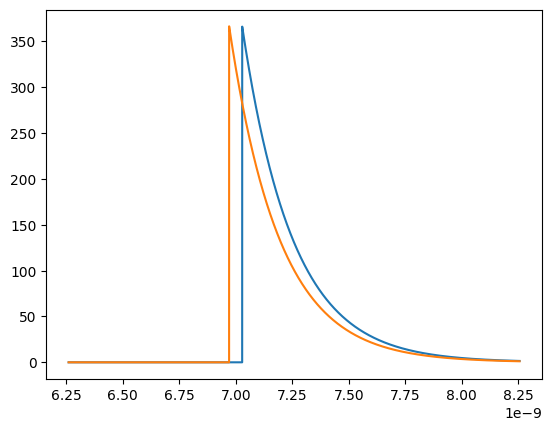

In [2]:
time, waves, delay, table, vHom, fullWaves = createWaves('./acquired_data/xp_05/data.json')

plt.plot(time,np.sqrt(waves[0]))
plt.plot(time,np.sqrt(waves[1]))



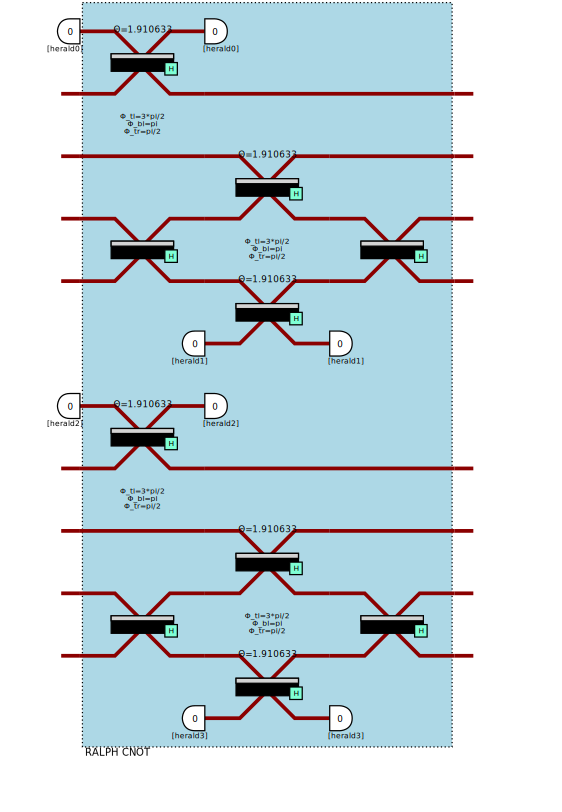

In [55]:
n = 3 #Nombre de modes spatiaux
m = 3 #Nombre de modes internes
k = 3 #Nombre de photon
cnot = pcvl.Circuit(12, name="Ralph CNOT")
cnot.add((0, 1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((3, 4), pcvl.BS.H())
cnot.add((2, 3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((4, 5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((3, 4), pcvl.BS.H())
#first copy
cnot.add((6, 7), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((9, 10), pcvl.BS.H())
cnot.add((8, 9), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((10, 11), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((9, 10), pcvl.BS.H())

p = pcvl.Processor("Naive", cnot)
p.set_postprocess(lambda s: (s[1] or s[2] or s[7] or s[8]) and (s[3] or s[4] or s[9] or s[10]))
p.add_herald(0, 0)
p.add_herald(5, 0)
p.add_herald(6, 0)
p.add_herald(11, 0)

pcvl.pdisplay(p, recursive = True)




In [35]:
def create_CRand(i,coef):
    CRand = []
    RawInputs = []
    Expected = []
    if i==0:
        CRand.append(np.array([[1,0],[0,0],[np.sqrt(1-coef ** 2),coef],[0,0]])) #Input = [1,0,1,0] = 0,0 exp = 0,0
        RawInputs.append([1,0,1,0])
        Expected = [1,0,1,0]
    elif i==1:
        CRand.append(np.array([[1,0],[0,0],[0,0],[np.sqrt(1-coef ** 2),coef]])) #Input = [1,0,0,1] = 0,1 exp = 0,1
        RawInputs.append([1,0,0,1])
        Expected = [1,0,0,1]
    elif i==2:
        CRand.append(np.array([[0,0],[1,0],[np.sqrt(1-coef ** 2),coef],[0,0]])) #Input = [0,1,1,0] = 1,0 exp = 1,1
        RawInputs.append([0,1,1,0])
        Expected = [0,1,0,1]
    elif i==3:
        CRand.append(np.array([[0,0],[1,0],[0,0],[np.sqrt(1-coef ** 2),coef]])) #Input = [0,1,0,1] = 1,1 exp = 1,0
        RawInputs.append([0,1,0,1])
        Expected = [0,1,1,0]
    else :
        print('Epic Fail')
        return
    return CRand, np.squeeze(RawInputs), Expected

# Create the C manually because it is not yet implemented
statesdict = {
    pcvl.BasicState([1,0,1,0]) : "00",
    pcvl.BasicState([1,0,0,1]) : "01",
    pcvl.BasicState([0,1,1,0]) : "10",
    pcvl.BasicState([0,1,0,1]) : "11"
}

def create_inputs(enterFunc,Coefs,Dictionnary = None): 
    #enterFunc is the distribution in space of the entry in the system ex: [1,1]
    if any(np.array(enterFunc)>1):
        raise Exception('Cannot be more than 1 photon per spatial mode')
        
    internMode = np.sum(enterFunc)
    spatialMode = len(enterFunc)
    nbPhoton = np.sum(enterFunc)
    L = spatialMode*internMode 

    Inputs = []
    for x in itertools.combinations(range(L), nbPhoton) :
        inputsTemps = [1 if i in x else 0 for i in range(L)]
        Inputs.append(np.array(inputsTemps))
    
    realInputs = []

    for i in range(len(Inputs)):
        compare = np.zeros(spatialMode)
        for ii in range(0,L,spatialMode):
            compare += Inputs[i][ii:ii+spatialMode]

        if np.all(compare == enterFunc):
            realInputs.append(Inputs[i])
    #print(realInputs)
    c = []
    Arr = np.squeeze(Coefs)
    
    for i in range(len(realInputs)):
        ArrCond = np.array(realInputs[i]).reshape(internMode,spatialMode).T
        y = np.ma.masked_array(Arr, abs(ArrCond-1))
        c.append(np.prod(y))

    k = 0

    if isinstance(Dictionnary,dict) and len(Dictionnary)!=0:
        testdict = {}

        iterkeys = itertools.permutations(Dictionnary.keys(),2)
        iterval = itertools.permutations(Dictionnary.values(),2)
        for i,j in zip(iterkeys,iterval) :
            dictkey = '|' + i[0] + ',' + i[1] + '>'
            dictval = j[0] + j[1]
            testdict[dictkey] = pcvl.BasicState(dictval)
        for i in realInputs:
            nameOfState = str(pcvl.BasicState(i))
            if k == 0:
                InputsBS = testdict[nameOfState]
                
            else:
                InputsBS = InputsBS + testdict[nameOfState]

            k += 1
        #Add the coefficient in the state vector
        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS,testdict
    else:     
        for i in realInputs:
            if k == 0 :
                InputsBS = pcvl.BasicState(i)
            else :
                InputsBS = InputsBS + pcvl.BasicState(i)
            k += 1
        #Add the coefficient in the state vector

        k = 0
        for state,amplitude in InputsBS.items():

            InputsBS[state] = amplitude*c[k]
            k+=1
        
        return InputsBS


In [22]:
""" 
waves = np.c_[env1Interp/np.sqrt(Overlap(env1Interp,env1Interp,extime)),env2Interp/np.sqrt(Overlap(env2Interp,env2Interp,extime))].T
new_base,coeffsMGS = modified_Schmidt(waves,extime) """


new_base,coeffsMGS = modified_Schmidt(waves,time)
coeff = coeffsMGS[1,1]
print(np.sum(coeffsMGS**2,axis = 1))
print(coeffsMGS)

[0.99946224 0.99858989]
[[0.99973109 0.        ]
 [0.28498103 0.95779732]]


In [23]:
TableValue = []

for vars in range(4):

    statesProb = dict.fromkeys(statesdict.keys(),0)

    
    
    [C,Inputs,Expected] = create_CRand(vars,coeff)
    InputsBS = create_inputs(Inputs,C)
    C = np.array(C)
    C = ((C + 0.007)/(1-0.007))**2
    #print(InputsBS)


    pcvl.pdisplay(p, recursive = True)
    realOutput = {}
    for i in range(len(InputsBS)):
        miniState = InputsBS[i]
        #print(miniState,':',InputsBS[miniState])
        p.with_input(miniState)
        output = p.probs()['results']
        for ii in output.keys():
            if ii in realOutput.keys():
                realOutput[ii] = realOutput[ii] + output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
            else:
                realOutput[ii] = output[ii] * abs(InputsBS[InputsBS[i]]) ** 2

    
    Prob = 0
    
    for states,val in zip(realOutput.keys(),realOutput.values()):
        ls = np.array(states)
        Cond = ls[0:4] + ls[4:]
        tempState = pcvl.BasicState(Cond)
        #print(tempState,val)
        if tempState in statesProb.keys():
            statesProb[tempState] += val

    results = {key: value  for key, value in statesProb.items()}
    TableValue.append(results)

1/2*|1,0,1,0,0,0,0,0>+1/2*|1,0,0,0,0,0,1,0>+1/2*|0,0,1,0,1,0,0,0>+1/2*|0,0,0,0,1,0,1,0>
[0.2874444216032452, 0.9577973191073234, 0.0, 0.0]
1/2*|1,0,0,1,0,0,0,0>+1/2*|1,0,0,0,0,0,0,1>+1/2*|0,0,0,1,1,0,0,0>+1/2*|0,0,0,0,1,0,0,1>
[0.2874444216032452, 0.9577973191073234, 0.0, 0.0]
1/2*|0,1,1,0,0,0,0,0>+1/2*|0,1,0,0,0,0,1,0>+1/2*|0,0,1,0,0,1,0,0>+1/2*|0,0,0,0,0,1,1,0>
[0.2874444216032452, 0.9577973191073234, 0.0, 0.0]
1/2*|0,1,0,1,0,0,0,0>+1/2*|0,1,0,0,0,0,0,1>+1/2*|0,0,0,1,0,1,0,0>+1/2*|0,0,0,0,0,1,0,1>
[0.2874444216032452, 0.9577973191073234, 0.0, 0.0]


In [7]:
table = [[] for i in range(len(statesdict.keys())+1)]
table[0] = list(statesdict.values())
k = 1
for i in statesdict.keys():
    l = 0
    for j in statesdict.keys():
        if l==0:
            table[k].append(statesdict[i])

        table[k].append(TableValue[k-1][j])
        print(table)
        l += 1
    k += 1

from tabulate import tabulate
print()
print(tabulate(table,headers='firstrow',tablefmt="fancy_grid"))

with open('shiftlist.txt','w+') as f:
    f.writelines(str(time))
    f.writelines('\n')
    f.writelines(str(table))

[['00', '01', '10', '11'], ['00', 1.0], [], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0], [], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0], [], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], [], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0, 0], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0, 0, 0], [], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0, 0, 0], ['10', 0], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0, 0, 0], ['10', 0, 0], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0, 0, 0], ['10', 0, 0, 0.43206010061916766], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0, 0, 0], ['10', 0, 0, 0.43206010061916766, 0.5679398993808323], []]
[['00', '01', '10', '11'], ['00', 1.0, 0, 0, 0], ['01', 0, 1.0,

Test pour voir la tendance 

0.997066*|0,1,1,0,0,0,0,0>+0.076549*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.928041*|0,1,1,0,0,0,0,0>+0.372477*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.862379*|0,1,1,0,0,0,0,0>+0.506263*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.811707*|0,1,1,0,0,0,0,0>+0.584065*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.707241*|0,1,1,0,0,0,0,0>+0.706972*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.594557*|0,1,1,0,0,0,0,0>+0.804053*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.491683*|0,1,1,0,0,0,0,0>+0.870774*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.423991*|0,1,1,0,0,0,0,0>+0.905667*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.338928*|0,1,1,0,0,0,0,0>+0.940812*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>
0.287444*|0,1,1,0,0,0,0,0>+0.957797*|0,1,0,0,0,0,1,0>
|0,1,1,0,0,0,0,0>
|0,1,0,0,0,0,1,0>


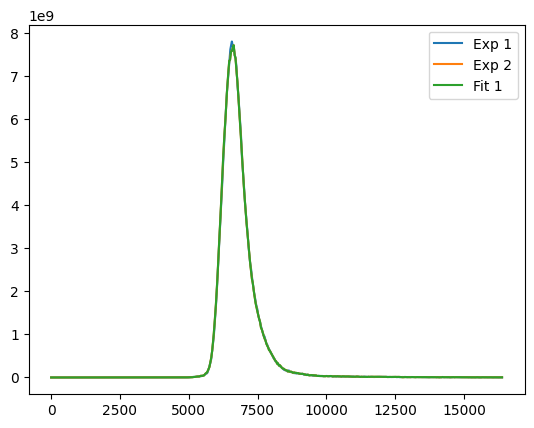

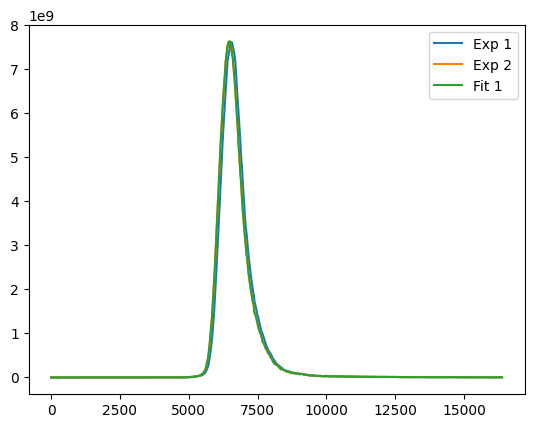

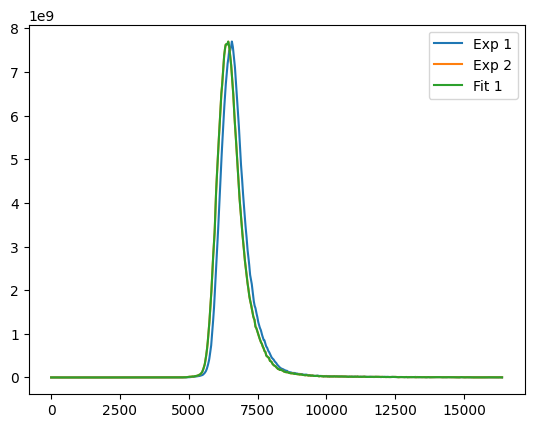

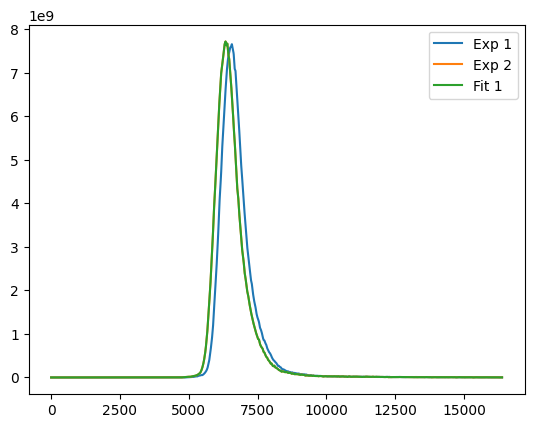

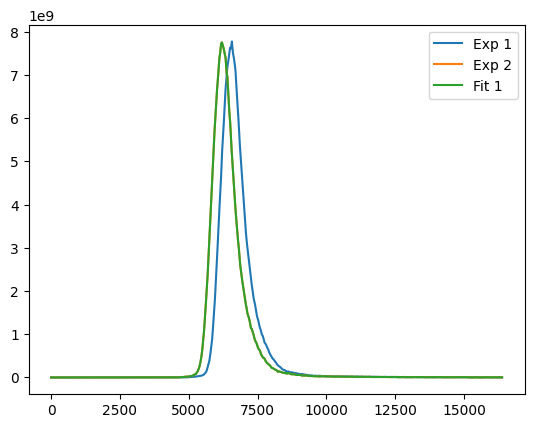

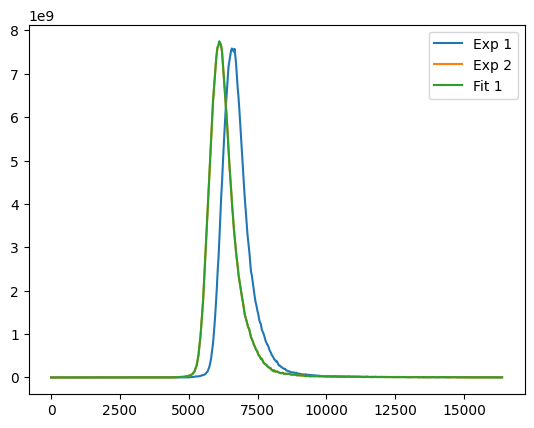

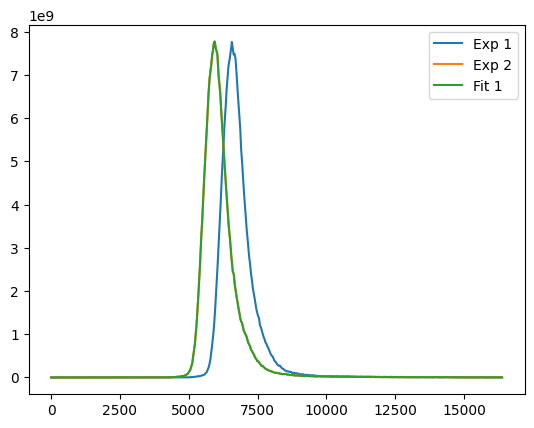

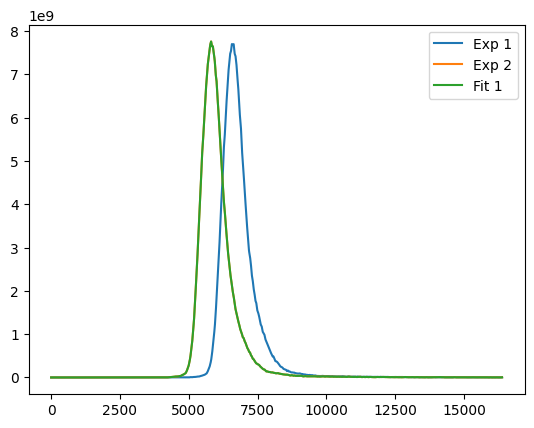

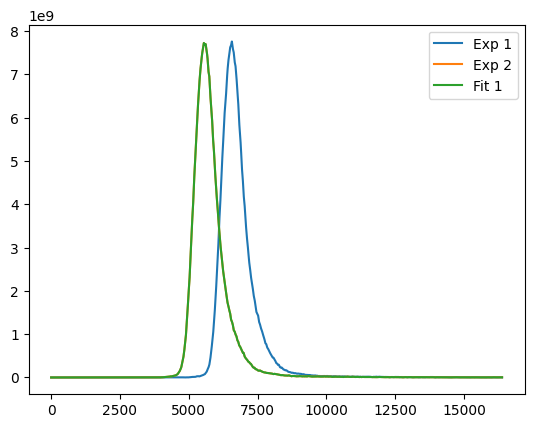

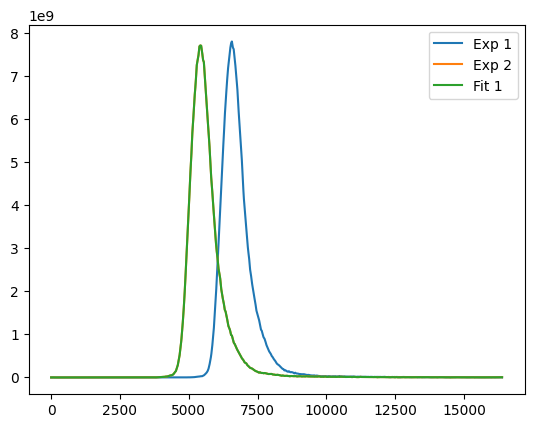

In [57]:
names = ['./acquired_data/xp_00/data.json','./acquired_data/xp_01/data.json','./acquired_data/xp_02/data.json','./acquired_data/xp_03/data.json','./acquired_data/xp_04/data.json','./acquired_data/xp_05/data.json','./acquired_data/xp_06/data.json','./acquired_data/xp_07/data.json','./acquired_data/xp_08/data.json','./acquired_data/xp_09/data.json']
compareVal = []
realValMax = []
realValMin = []
delayVal = []
for i in names:
    time, waves, delay, table, vHom, fullWaves = createWaves(i,doYouPlot = True,timeArray=2 ** 14 +1 )
    new_base,coeffsMGS = modified_Schmidt(waves,time)
    coeff = coeffsMGS[1,1]
    TableValue = []
    

    statesProb = dict.fromkeys(statesdict.keys(),0)

    [C,Inputs,Expected] = create_CRand(2,coeff)
    C = np.array(C)
    #C = (C)
    InputsBS = create_inputs(Inputs,C)

    print(InputsBS)


    pcvl.pdisplay(p, recursive = True)
    realOutput = {}
    for i in range(len(InputsBS)):
        miniState = InputsBS[i]
        print(miniState)
        #print(miniState,':',InputsBS[miniState])
        p.with_input(miniState)
        output = p.probs()['results']
        for ii in output.keys():
            if ii in realOutput.keys():
                realOutput[ii] = realOutput[ii] + output[ii] * abs(InputsBS[InputsBS[i]]) ** 2
            else:
                realOutput[ii] = output[ii] * abs(InputsBS[InputsBS[i]]) ** 2 


    Prob = 0
    
    for states,val in realOutput.items():
        ls = np.array(states)
        Cond = ls[0:4] + ls[4:]
        tempState = pcvl.BasicState(Cond)
        #print(tempState,val)
        if tempState in statesProb.keys():
            statesProb[tempState] += val

    results = {key: value / 1 for key, value in statesProb.items()}
    #print(results)

    TableValue.append(results)
    A = pcvl.BasicState([0,1,0,1])
    compareVal.append(statesProb[A])
    realValMax.append(table[2,3])
    realValMin.append(table[3,2])
    delayVal.append(delay)

[0.3262157686685896, 8.427415610921344, 16.539841281311965, 23.072866831244028, 38.198807128899716, 58.1518225709533, 78.48797956716226, 94.47494814804486, 120.23891949149129, 139.0909882324122]
[0.8642579622718675, 0.8047923390521488, 0.7054251404774808, 0.6339745050794477, 0.5461695118517895, 0.4766937733580512, 0.43860164512338423, 0.4189242141122594, 0.40579429674169615, 0.3961424802780103]
[0.8406719080700941, 0.7745697232329014, 0.6666681805382721, 0.5867515037344204, 0.48462078230728817, 0.4079839932507154, 0.36419810954361737, 0.34285192323031677, 0.3238514845257066, 0.3143758125639678]
[0.9960935343727828, 0.9075070882328209, 0.8291316500262861, 0.7725784513738744, 0.6667934223838078, 0.5689986690114734, 0.4945017349751751, 0.45317874000931113, 0.4099149320662094, 0.38841619700721614]


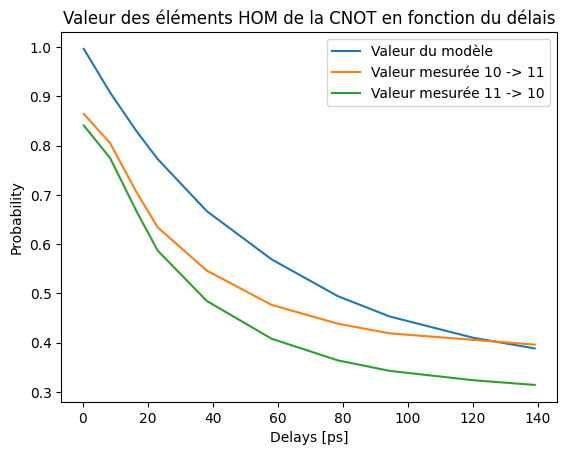

In [58]:
print(delayVal)
print(realValMax)
print(realValMin)

plt.plot(delayVal,np.array(compareVal),label = 'Valeur du modèle')
plt.plot(delayVal,realValMax,label = 'Valeur mesurée 10 -> 11')
plt.plot(delayVal,realValMin,label = 'Valeur mesurée 11 -> 10')
plt.xlabel('Delays [ps]')
plt.ylabel('Probability')
plt.title(r'Valeur des éléments HOM de la CNOT en fonction du délais')
plt.legend()
print(compareVal)

In [16]:
print(np.array(compareVal)**1/2)


[0.49998842 0.49156892 0.46461246 0.42953319 0.33346009 0.24338732
 0.1974244  0.18194427 0.17218801 0.16934887]


In [11]:
table = [[] for i in range(len(statesdict.keys())+1)]
table[0] = list(statesdict.values())
k = 1
for i in statesdict.keys():
    l = 0
    for j in statesdict.keys():
        if l==0:
            table[k].append(statesdict[i])

        table[k].append(TableValue[k-1][j])
        
        l += 1
    k += 1

from tabulate import tabulate
print(table[4])
print(tabulate(table,headers='firstrow',tablefmt="fancy_grid"))

with open('shiftlist.txt','w+') as f:
    f.writelines(str(time))
    f.writelines('\n')
    f.writelines(str(table))

IndexError: list index out of range